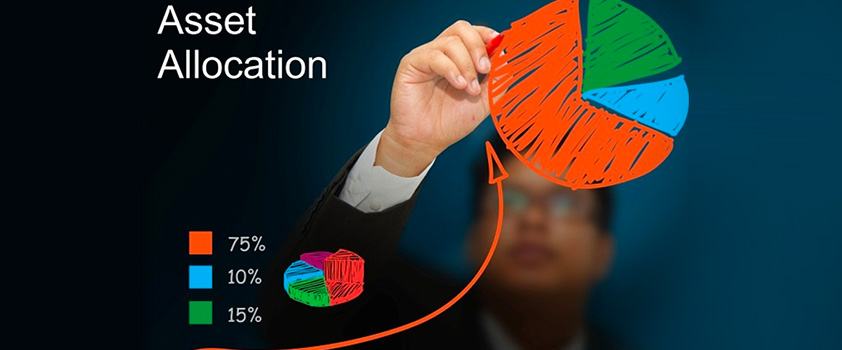

In [36]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np

In [37]:
# Definindo os símbolos dos índice IBOV e ETF IVVB11 (S&P[IVV] + DÓLAR)
ibov_symbol = '^BVSP'  # Índice IBOV
ivvb11_symbol = 'IVVB11.SA'  # ETF do S&P 500 na B3 (Bolsa de Valores do Brasil) - Início limitado (maio/2016)

# Definindo a data inicial e final para as cotações históricas do estudo
start_date = '2003-01-01'
end_date = '2023-10-26'

# Baixando os dados históricos usando yfinance
ibov_data = yf.download(ibov_symbol, start=start_date, end=end_date)
ivvb11_data = yf.download(ivvb11_symbol, start=start_date, end=end_date)

# Baixando dados IFIX (está em planilha Excel, usei GOOGLEFINANCE & Google Sheets). YFinance está sem os dados.
ifix_data = pd.read_excel('Historico IFIX 01-01-2013 ate 20-10-2023.xlsx')

# Filtrando os registros com datas a partir de start_date, para igualar o período dos outros índices (Início IFIX set/2012)
ifix_data = ifix_data[ifix_data['Date'] >= start_date]
# Fazendo também com o end_date
ifix_data = ifix_data[ifix_data['Date'] <= end_date]

# Padronizando as datas no DataFrame ifix_data para 00:00:00 (elas vem com horário de encerramento [~16h56] e causa problemas)
ifix_data['Date'] = ifix_data['Date'].dt.floor('D')

# Definindo a coluna "Date" da planilha como o índice do DataFrame
ifix_data = ifix_data.set_index('Date')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [38]:
# Consultando o Dados Abertos do BC para ter a Taxa Selic anualizada - Renda Fixa (CDI)

# Função de Busca dos Dados - Irei buscar a taxa Selic diaria (mais facil para aplicar a um investimento e comparar com os indices)

def CarregaDadosSelic(data_inicial, data_final):
    # Carrega um intervalo de taxas Selic no período data inicial até data final
    url_bcb = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={data_inicial}&dataFinal={data_final}'
    
    selic_historica = pd.read_json(url_bcb)
    return selic_historica

# Execução

# Convertendo a data do formato americano (yahoofinance) de str para objeto data
start_date_dttime = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dttime = datetime.strptime(end_date, '%Y-%m-%d')
# Formatando a data no novo padrão 'DD/MM/YYYY'
start_date_br = start_date_dttime.strftime('%d/%m/%Y')
end_date_br = end_date_dttime.strftime('%d/%m/%Y')

# Carregando e jogando em um DataFrame
selic_data = CarregaDadosSelic(start_date_br, end_date_br)
selic_data.rename(columns={'data': 'Date', 'valor': 'Close'}, inplace=True)

# Definindo a data como um índice e também no formato 'YYYY-MM-DD', do mesmos outros dfs
selic_data = selic_data.set_index('Date')
selic_data.index = pd.to_datetime(selic_data.index, format='%d/%m/%Y')

# Certo. Agora tenho o gráfico da Selic histórica média últimos 12 meses (252 dias úteis). Mas quero ver a linha de investimento
# de estar 100% CDI, ou seja, replicando essa taxa Selic over.

# OBSERVAÇÃO IMPORTANTE: Esta será também a taxa livre de risco (RF rate) para cálculo de índice Sharpe

# Também vou começar de base 100, como os outros índices
valor_inicial = 100
selic_data['Close Adj'] = 0
selic_data.loc[selic_data.index[0], 'Close Adj'] = valor_inicial

# Simulando o investimento 100% na Taxa Selic
for i in range(1, len(selic_data)):
    # Calculando o valor do investimento dia a dia com base na taxa SELIC
    selic_data.loc[selic_data.index[i], 'Close Adj'] = selic_data.loc[selic_data.index[i - 1], 'Close Adj'] * (1 + selic_data['Close'][i] / 100)


In [39]:
# Capturando o "Real IVVB11", que seria a variação do S&P500 + a variação do Dólar/BRL. Isso porque a data do histórico de
# criação do ETF está limitando a janela de análise (maio/2016)

# Definindo os símbolos da cotação Dólar/Real e S&P 500
dollar_symbol = 'BRL=X'  # Símbolo do dólar
sp500_symbol = 'IVV'     # Símbolo do S&P 500 (IVV)

# Baixando os dados
dollar_data = yf.download(dollar_symbol, start=start_date, end=end_date)
sp500_data = yf.download(sp500_symbol, start=start_date, end=end_date)

# Unindo os DataFrames usando a data e hora como índice
dollar_ivv = pd.concat([dollar_data['Close'], sp500_data['Close']], axis=1)
dollar_ivv.columns = ['Dollar', 'SP500']
dollar_ivv = dollar_ivv.drop(dollar_ivv.index[0])

# Calculando a variação percentual intraday para ambos os ativos
dollar_ivv['Dollar_Return'] = dollar_ivv['Dollar'].pct_change()
dollar_ivv['SP500_Return'] = dollar_ivv['SP500'].pct_change()

# Somando as duas variações percentuais (S&P 500 e USD/BRL) para criar o índice desejado
dollar_ivv['IVV'] = dollar_ivv['Dollar_Return'] + dollar_ivv['SP500_Return']
# Ajustando o valor da primeira linha para 0 (sem variação)
dollar_ivv['IVV'].iloc[0] = 0

# Passando o índice criado (S&P+Dólar) para base 100 a partir da segunda linha
dollar_ivv['IVV Adj'] = (1 + dollar_ivv['IVV']).cumprod() * 100


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


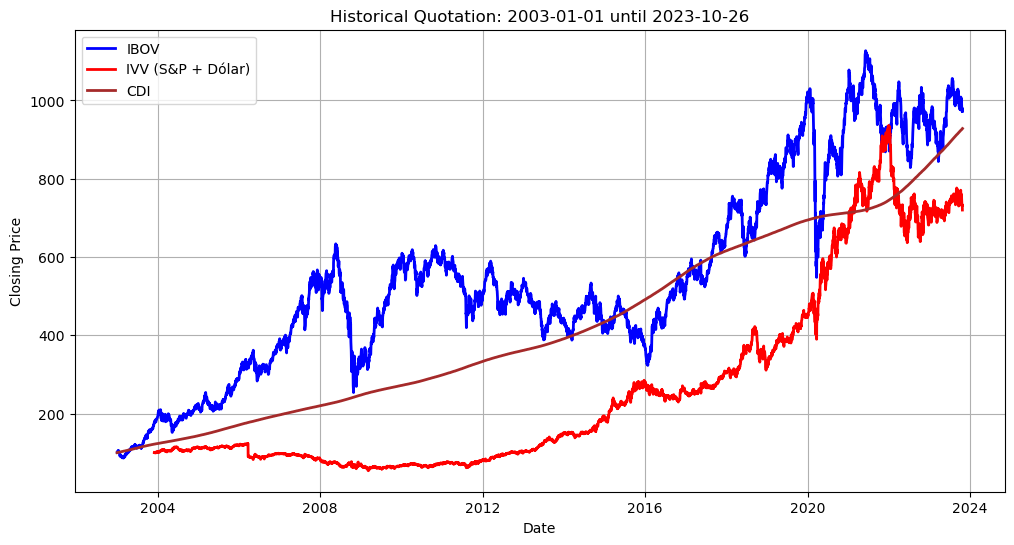

In [40]:
# Valor base comum entre os índices (para que comecem no mesmo ponto no gráfico)
valor_base = 100

# Normalizando os DataFrames dividindo pela base comum
ibov_data['Close'] = ibov_data['Close'] / ibov_data['Close'].iloc[0] * valor_base
ifix_data['Close'] = ifix_data['Close'] / ifix_data['Close'].iloc[0] * valor_base

# Criando o gráfico
plt.figure(figsize=(12, 6))

plt.plot(ibov_data.index, ibov_data['Close'], label='IBOV', color='blue', linewidth=2)
plt.plot(dollar_ivv.index, dollar_ivv['IVV Adj'], label='IVV (S&P + Dólar)', color='red', linewidth=2)
#plt.plot(ifix_data.index, ifix_data['Close'], label='IFIX', color='green', linewidth=2)
plt.plot(selic_data.index, selic_data['Close Adj'], label='CDI', color='brown', linewidth=2)

plt.title(f'Historical Quotation: {start_date} until {end_date}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Exiba o gráfico no Jupyter Notebook
plt.show()

In [41]:
# Fazendo o cálculo de média-variância (para modelo MVO), retornos esperados e volatilidade (desvio) esperada, baseada 
# no histórico. Executando múltiplas janelas para redução do viés de enquadramento

janelas_tempo = [252, 252 * 3, 252 * 5, 252 * 10]  # 252 dias úteis = 1 ano (pregões). 1 ano, 3 anos, 5 anos, 10 anos.
nome_janelas = ['1 ano', '3 anos', '5 anos', '10 anos']

# Renomeando coluna para poder colocar todos os retornos em um único df
ifix_data.rename(columns={'Close': 'Close IFIX'}, inplace=True)

# DF com a variação de todos os índices
all_classes_return = pd.concat([ibov_data['Close'], dollar_ivv['IVV Adj'], selic_data['Close Adj'], 
                                ifix_data['Close IFIX']], axis=1)
# Renomeando as colunas
all_classes_return.rename(columns={'Close': 'IBOV', 'IVV Adj': 'IVV', 'Close Adj': 'CDI', 'Close IFIX': 'IFIX'}, inplace=True)
# Preenchendo os valores ausentes (NaN) usando interpolação linear
all_classes_return = all_classes_return.interpolate(method='linear')

# Criando um DataFrame para armazenar os resultados das janelas de tempo
windows_results = pd.DataFrame(index=all_classes_return.index)

# Iterando pelas janelas de tempo
for janela, nome in zip(janelas_tempo, nome_janelas):
    nome_coluna = f'Retorno_{nome}'
    retorno_janela = all_classes_return.pct_change().rolling(window=janela).apply(lambda x: np.prod(1 + x) - 1)
    taxa_retorno_anualizado = (1 + retorno_janela) ** (252 / janela) - 1
    for coluna in taxa_retorno_anualizado.columns:
        windows_results[f'{coluna}_{nome_coluna}'] = taxa_retorno_anualizado[coluna]

windows_results.tail()

,IBOV_Retorno_1 ano,IVV_Retorno_1 ano,CDI_Retorno_1 ano,IFIX_Retorno_1 ano,IBOV_Retorno_3 anos,IVV_Retorno_3 anos,CDI_Retorno_3 anos,IFIX_Retorno_3 anos,IBOV_Retorno_5 anos,IVV_Retorno_5 anos,CDI_Retorno_5 anos,IFIX_Retorno_5 anos,IBOV_Retorno_10 anos,IVV_Retorno_10 anos,CDI_Retorno_10 anos,IFIX_Retorno_10 anos
Date,,,,,,,,,,,,,,,,
2023-10-20,-0.032139,0.109781,0.129526,0.060048,0.008777,0.033950,0.091670,0.042019,0.057162,0.182501,0.072006,0.063396,0.090958,0.172136,0.088545,0.095236
2023-10-23,-0.035168,0.112040,0.129773,0.060119,0.006618,0.029440,0.091815,0.040640,0.056932,0.186516,0.072055,0.063333,0.090570,0.172140,0.088554,0.094531
2023-10-24,-0.037180,0.106521,0.129734,0.058592,0.014703,0.031827,0.091960,0.041007,0.059220,0.183780,0.072130,0.063271,0.093083,0.172738,0.088563,0.093472
2023-10-25,-0.021779,0.083295,0.129694,0.060672,0.004456,0.022421,0.092105,0.041631,0.057943,0.168123,0.072205,0.063208,0.092458,0.170429,0.088572,0.092885
2023-10-26,-0.028667,0.061812,0.129654,0.062031,0.003020,0.029872,0.092249,0.042348,0.057140,0.164831,0.072253,0.062045,0.090123,0.169351,0.088579,0.091823


In [66]:
# Criando DataFrames com as métricas de: Média de Retorno (das múltiplas janelas) e Desvio-Padrão dos retornos (risco/volatilidade)

# Lista que armazenará os dfs
lista_dfs_retornos = []

# Loop para criar os DataFrames de média e desvio-padrão
for janela in nome_janelas:
    columns = [f'{indice}_Retorno_{janela}' for indice in ['IBOV', 'IVV', 'CDI', 'IFIX']]
    df_janelas = windows_results[columns]
    
    # Média de Retornos na Janela
    avg_return = df_janelas.mean()
    # Desvio-Padrão dos Retornos na Janela
    sd_return = df_janelas.std()
    if columns[0].str[:3] == 'CDI':
        # Retorno do CDI na Janela (Taxa Livre de Risco)
        risk_free_rate = df_janelas.mean()
    # Sharpe Ratio
    #sharpe_ratio = (avg_return - risk_free_rate) / sd_return
    
    df_estatisticas = pd.DataFrame({
        'Média': avg_return * 100,
        'Desvio-Padrão': sd_return * 100,
        'Risk-Free': risk_free_rate
    })

    lista_dfs_retornos.append(df_estatisticas)

lista_dfs_retornos

AttributeError: 'str' object has no attribute 'str'

In [43]:
# Janela de 1 ano

# Matriz de Correlação



correlation_matrix = dados_combinados.corr()

# Cria um mapa de calor usando o Seaborn
plt.figure(figsize=(6, 4))  # Define o tamanho da figura
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Matriz de Correlação')  # Define o título do gráfico
plt.show()


NameError: name 'dados_combinados' is not defined

In [ ]:
# Gerando grafico para janelas de 1 ano

# Selecionando apenas as colunas de janelas com 1 ano
colunas = ["IBOV_Retorno_1 ano", "IVV_Retorno_1 ano", "CDI_Retorno_1 ano", "IFIX_Retorno_1 ano"]

# Criando um gráfico de linhas para exibir os retornos
resultados[colunas] = resultados[colunas] * 100  # Multiplicar por 100 para obter porcentagens
resultados[colunas].plot(figsize=(12, 6))
plt.title("Retornos Anuais dos 4 Índices na Janela de 252 Dias (1 ano)")
plt.xlabel("Data")
plt.ylabel("Retorno (%)")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Gerando grafico para janelas de 3 anos

# Selecionando apenas as colunas de janelas com 3 anos
colunas = ["IBOV_Retorno_3 anos", "IVV_Retorno_3 anos", "CDI_Retorno_3 anos", "IFIX_Retorno_3 anos"]

# Criando um gráfico de linhas para exibir os retornos
resultados[colunas] = resultados[colunas] * 100  # Multiplicar por 100 para obter porcentagens
resultados[colunas].plot(figsize=(12, 6))
plt.title("Retornos Anuais dos 4 Índices na Janela de 756 Dias (3 anos)")
plt.xlabel("Data")
plt.ylabel("Retorno (%)")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Gerando grafico para janelas de 5 anos

# Selecionando apenas as colunas de janelas com 5 anos
colunas = ["IBOV_Retorno_5 anos", "IVV_Retorno_5 anos", "CDI_Retorno_5 anos", "IFIX_Retorno_5 anos"]

# Criando um gráfico de linhas para exibir os retornos
resultados[colunas] = resultados[colunas] * 100  # Multiplicar por 100 para obter porcentagens
resultados[colunas].plot(figsize=(12, 6))
plt.title("Retornos Anuais dos 4 Índices na Janela de 1260 Dias (5 anos)")
plt.xlabel("Data")
plt.ylabel("Retorno (%)")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Gerando grafico para janelas de 10 anos

# Selecionando apenas as colunas de janelas com 10 anos
colunas = ["IBOV_Retorno_10 anos", "IVV_Retorno_10 anos", "CDI_Retorno_10 anos", "IFIX_Retorno_10 anos"]

# Criando um gráfico de linhas para exibir os retornos
resultados[colunas] = resultados[colunas] * 100  # Multiplicar por 100 para obter porcentagens
resultados[colunas].plot(figsize=(12, 6))
plt.title("Retornos Anuais dos 4 Índices na Janela de 2520 Dias (10 anos)")
plt.xlabel("Data")
plt.ylabel("Retorno (%)")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [ ]:
import plotly.express as px

fig = px.line(resultados, x=resultados.index, y='IBOV_Retorno_1 ano')
fig.show()